# House Model Development and Analysis

<a id='contents' />

### Table of contents

1. [Introduction](#intro)
2. [Model development](#development)
4. [Model analysis](#analysis)

<a id='intro' />

### 1. Introduction

The aim of this notebook is to develop a gradient boosting model to predict house sale prices based on the provided dataset "challenge_houses-prices.csv". 

In the first section, Model Development, we preprocess the data, split it into train and testing sets, and run a bayesian optimization on the training/validation sets in order to find the best hyperparameters for the model. Then we evaluate the model in the test set as measured by the mean absolute error. 

Finally, in the Model Analysis section, we take a look at the most important predictors and analyze how they impact on the houses sale prices.

<a id='development' />

### 2. Model Development

In [ ]:
import pandas as pd

df = pd.read_csv("../challenge_houses-prices.csv")

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

In [3]:
df.head()

,property_area,house_age,house_style,neighborhood,overall_quality,overall_condition,spaciousness,liv_lot_ratio,remodel_age,bath_area,bsmt_area,garage_area,garage_age,has_2ndfloor,has_porch,has_pool,has_multiple_kitchen,sale_price
0,2501,12,2Story,Gilbert,6,5,207.0,0.0,15,2.5,775,386,12.0,1,1,0,0,110000
1,1704,87,1.5Fin,OldTown,6,7,225.0,0.0,19,1.5,666,261,82.0,1,1,0,0,145203
2,2253,92,1.5Fin,OldTown,5,7,203.0,1.0,57,2.0,625,57,NaN,1,1,0,0,120359
3,1788,75,1Story,BrkSide,5,7,165.0,0.0,59,1.0,838,228,89.0,0,1,0,0,92758
4,1361,42,1Story,Edwards,5,5,191.0,0.0,52,1.0,645,457,50.0,0,1,0,0,114073


In [4]:
df.shape

(50000, 18)

In [3]:
df.dtypes

property_area             int64
house_age                 int64
house_style              object
neighborhood             object
overall_quality           int64
overall_condition         int64
spaciousness            float64
liv_lot_ratio           float64
remodel_age               int64
bath_area               float64
bsmt_area                 int64
garage_area               int64
garage_age              float64
has_2ndfloor              int64
has_porch                 int64
has_pool                  int64
has_multiple_kitchen      int64
sale_price                int64
dtype: object

In [8]:
df_house_style = pd.get_dummies(df['house_style'])
df_neighborhood = pd.get_dummies(df['neighborhood'])

In [9]:
df = pd.concat([df, df_house_style, df_neighborhood], axis=1)

In [10]:
df.drop(['house_style','neighborhood'], axis=1, inplace=True)

In [11]:
for column in df.columns:
    df[column] = df[column].astype(float)

In [12]:
df.shape

(50000, 46)

In [13]:
df.head()

,property_area,house_age,overall_quality,overall_condition,spaciousness,liv_lot_ratio,remodel_age,bath_area,bsmt_area,garage_area,...,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber
0,2501.0,12.0,6.0,5.0,207.0,0.0,15.0,2.5,775.0,386.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1704.0,87.0,6.0,7.0,225.0,0.0,19.0,1.5,666.0,261.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2253.0,92.0,5.0,7.0,203.0,1.0,57.0,2.0,625.0,57.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1788.0,75.0,5.0,7.0,165.0,0.0,59.0,1.0,838.0,228.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1361.0,42.0,5.0,5.0,191.0,0.0,52.0,1.0,645.0,457.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
y = df['sale_price']
X = df.drop('sale_price', axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state = 42)

In [63]:
import xgboost as xgb

def XGB_CV(
        learning_rate,
        max_leaves,
        lambda1,
        lambda2,
        max_bin,
        max_depth,
        gamma,
        min_child_weight,
        max_delta_step,
        subsample,
        colsample_bytree,
        ):

    global rmse_best
    global mae_best
    global iter_best

    paramt = {
              'nthread' : 4,
              'seed' : 1001,
              'objective' : 'reg:squarederror',
              'eval_metric': ['rmse', 'mae'],
              'booster' : 'gbtree',
              'eta' : learning_rate,
              'gamma' : gamma,
              'max_depth' : int(max_depth),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'alpha': lambda1,
              'lambda': lambda2,
              'max_leaves': int(max_leaves),
              'max_bin': int(max_bin),
              }

    folds = 5
    cv_score = 0

    print("\n Search parameters (%d-fold validation):\n %s" % (folds, paramt), file=log_file )
    log_file.flush()

    xgbc = xgb.cv(
        paramt,
        dtrain,
        num_boost_round = 100,
        nfold = folds,
        verbose_eval = 10,
        #early_stopping_rounds = 100,
        metrics = ['rmse','mae'],
        show_stdv = True
    )

    val_score = xgbc['test-rmse-mean'].iloc[-1]
    train_score = xgbc['train-rmse-mean'].iloc[-1]
    print(
        'Stopped after %d iterations with train-rmse = %f val-rmse = %f' % ( 
            len(xgbc), 
            train_score,
            val_score
        ) 
    )

    if ( val_score < rmse_best ):
        rmse_best = val_score
        iter_best = len(xgbc)

    return -val_score

In [64]:
# Define the log file. If you repeat this run, new output will be added to it
log_file = open('challenge-rmse-5fold-XGB-run-01-v1-full.log', 'a')
rmse_best = -1.
iter_best = 0

In [65]:
dtrain = xgb.DMatrix(X_train, label = y_train)

In [66]:
bounds = {
    'learning_rate': (0.001, 0.2),
    'max_leaves': (8, 1024),
    'lambda1': (0.1, 100),
    'lambda2': (0.1, 100),
    'max_bin': (3, 1023),
    'max_depth': (-1, 20),
    'gamma': (0.001, 10.0),
    'min_child_weight': (0, 20),
    'max_delta_step': (0, 10),
    'subsample': (0.1, 1.0),
    'colsample_bytree' :(0.1, 1.0)
}

In [67]:
XGB_BO = BayesianOptimization(
    f=XGB_CV, 
    pbounds=bounds,
)

In [70]:
print('-'*130)
print('-'*130, file=log_file)
log_file.flush()

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    XGB_BO.maximize(init_points=2, n_iter=50)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | colsam... |   gamma   |  lambda1  |  lambda2  | learni... |  max_bin  | max_de... | max_depth | max_le... | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Stopped after 100 iterations with train-rmse = 191160.843750 val-rmse = 191159.087500
|  25       | -1.912e+0 |  0.3627   |  3.695    |  64.86    |  70.71    |  0.1122   |  755.2    |  1.536    |  8.471    |  282.9    |  1.521    |  0.1096   |
Stopped after 100 iterations with train-rmse = 191161.403125 val-rmse = 191159.681250
|  26       | -1.912e+0 |  0.734    |  8.678    |  17.37    |  14.34    |  0.01767  |  409.3    |  6.307    |  3.172    |  930.4    |  15.98    |  0.5131   |
Stopped after 100 iterations with train-rmse = 191104.296875 val-

In [75]:
XGB_BO.max

{'target': -34906.491406400004,
 'params': {'colsample_bytree': 0.8832635679721044,
  'gamma': 1.7659450508306334,
  'lambda1': 70.27689014791974,
  'lambda2': 41.17989096578065,
  'learning_rate': 0.09192742232542225,
  'max_bin': 484.929853363818,
  'max_delta_step': 0.4252788214274317,
  'max_depth': 6.223921658901861,
  'max_leaves': 932.853965644163,
  'min_child_weight': 6.997838154971065,
  'subsample': 0.13915515897442735}}

In [16]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=100,
    objective='reg:squarederror',
    eval_metric=['rmse', 'mae'],
    booster='gbtree',
    eta=0.09192742232542225,
    gamma=1.7659450508306334,
    max_depth=6,
    min_child_weight=6.997838154971065,
    max_delta_step=0,
    subsample=0.13915515897442735,
    colsample_bytree=0.8832635679721044,
    reg_alpha=70.27689014791974,
    reg_lambda=41.17989096578065,
    max_leaves=932,
    max_bin=484,
    n_jobs=-1,
    random_state=1,
)

In [17]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [18]:
model.fit(X_train, y_train, eval_set=eval_set, verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8832635679721044,
             eta=0.09192742232542225, eval_metric=['rmse', 'mae'],
             gamma=1.7659450508306334, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0919274241,
             max_bin=484, max_delta_step=0, max_depth=6, max_leaves=932,
             min_child_weight=6.997838154971065, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, random_state=1, reg_alpha=70.27689014791974,
             reg_lambda=41.17989096578065, scale_pos_weight=1,
             subsample=0.13915515897442735, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [19]:
results = model.evals_result()

In [21]:
y_pred = model.predict(X_test)

<a id='analysis' />

### 3. Model Analysis

In [36]:
sorted_idx = model.feature_importances_.argsort()
cols = np.array(X.columns)[sorted_idx]
imp_values = model.feature_importances_[sorted_idx]

Based on feature importance, overall quality and bath area of the properties are the main predictors of the sale price

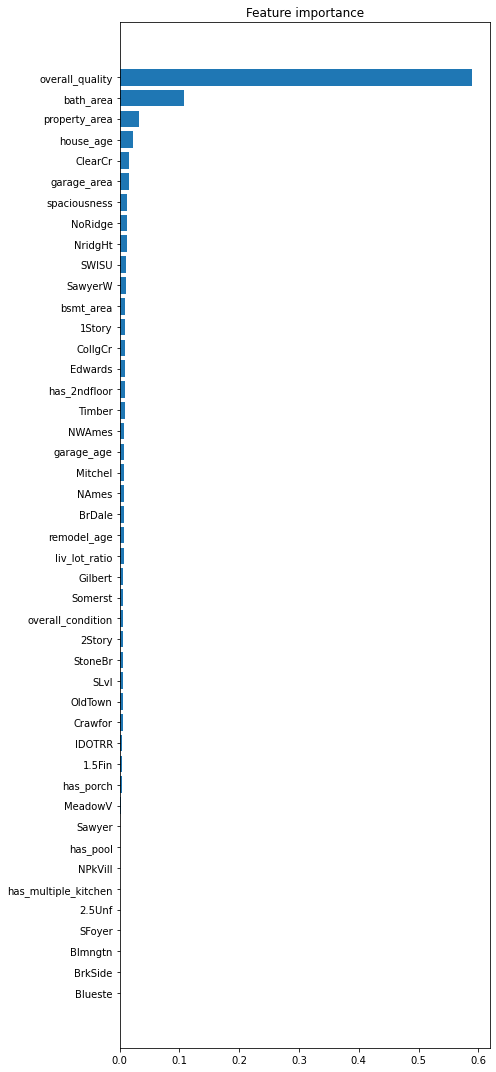

In [39]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7,15)
fig = plt.barh(cols, imp_values)
plt.title('Feature importance')
plt.tight_layout()

We can confirm positive associations between the sale price and those two variables in the following plots

Text(0.5, 0, 'Bath area')

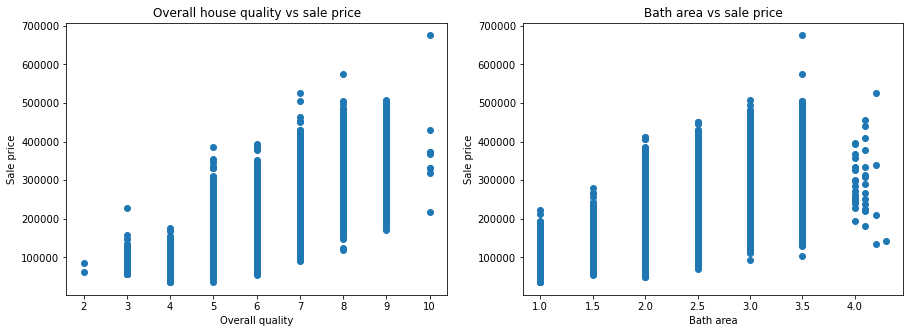

In [47]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(1, 2, 1)
plt.scatter(df.overall_quality, df.sale_price)
plt.title('Overall house quality vs sale price')
plt.ylabel('Sale price')
plt.xlabel('Overall quality')

plt.subplot(1, 2, 2)
plt.scatter(df.bath_area, df.sale_price)
plt.title('Bath area vs sale price')
plt.ylabel('Sale price')
plt.xlabel('Bath area')

Looking at the rest of the important features, we can observe that they are also strongly correlated to the sale price. As expected, property area, garage area and spaciousness correlate positively to the sale price, while house age has a negative impact on the price.

Text(0.5, 0, 'Spaciousness')

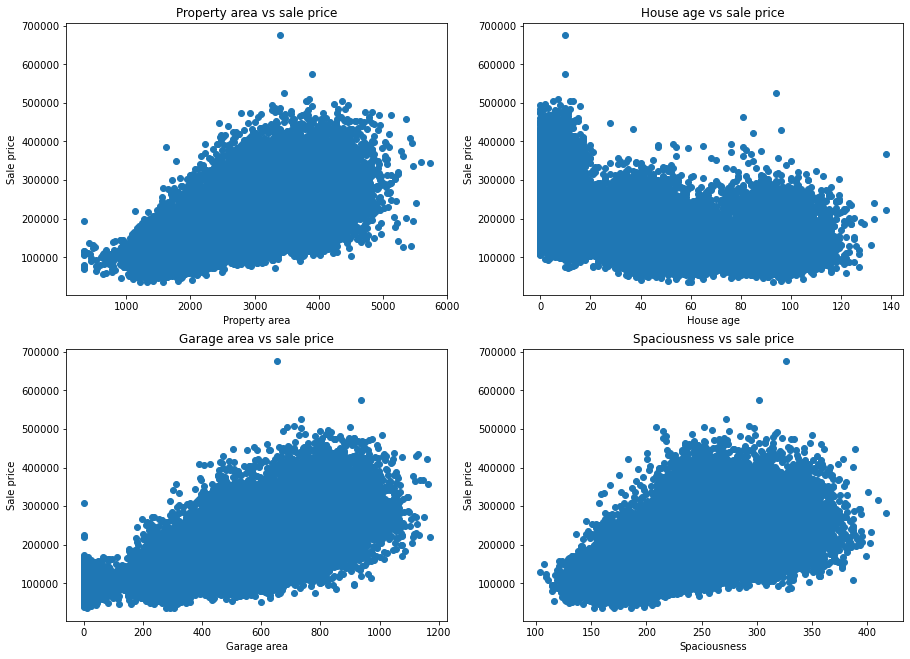

In [56]:
plt.rcParams["figure.figsize"] = (15,11)

plt.subplot(2, 2, 1)
plt.scatter(df.property_area, df.sale_price)
plt.title('Property area vs sale price')
plt.ylabel('Sale price')
plt.xlabel('Property area')

plt.subplot(2, 2, 2)
plt.scatter(df.house_age, df.sale_price)
plt.title('House age vs sale price')
plt.ylabel('Sale price')
plt.xlabel('House age')

plt.subplot(2, 2, 3)
plt.scatter(df.garage_area, df.sale_price)
plt.title('Garage area vs sale price')
plt.ylabel('Sale price')
plt.xlabel('Garage area')

plt.subplot(2, 2, 4)
plt.scatter(df.spaciousness, df.sale_price)
plt.title('Spaciousness vs sale price')
plt.ylabel('Sale price')
plt.xlabel('Spaciousness')

Finally, we plot all the correlation coefficients that confirm what we observed in the graphs

In [63]:
numeric_cols = [
    'sale_price', 'overall_condition', 'liv_lot_ratio', 
    'remodel_age', 'garage_age', 'bsmt_area',
    'spaciousness', 'garage_area', 'house_age',
    'property_area', 'bath_area', 'overall_quality'
]
correlations = df[numeric_cols].corr()['sale_price'].sort_values(ascending=False)

In [64]:
correlations

sale_price           1.000000
overall_quality      0.798240
bath_area            0.708489
property_area        0.703008
garage_area          0.667862
spaciousness         0.600601
bsmt_area            0.509558
liv_lot_ratio       -0.046280
overall_condition   -0.268677
house_age           -0.569701
garage_age          -0.576104
remodel_age         -0.580351
Name: sale_price, dtype: float64